This notebook presents a thorough description of the thermal model that has been developed in the framework of Gauthier Patin's PhD at the University of Amsterdam.

# Import

In [1]:
%pylab inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

from tqdm.auto import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt

from ipywidgets import Layout, Button, Box, interact, interactive, fixed, interact_manual
import ipywidgets as wg
from IPython.display import display, clear_output

import Thermal_simulation_class
import Thermal_model
import Thermal_model_GIU

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Table of symbols 

| Symbol        | Unit        | Description  |
|:----------    |:------------|:-------------|
| $\alpha$      | m$^2$/s     | thermal diffusivity |
| $A_E$         | m$^2$       | area of east wall |
| $A_W$         | m$^2$       | area of west wall |
| $A_N$         | m$^2$       | area of north wall |
| $A_S$         | m$^2$       | area of south wall |
| $C_p$         | J/(kg K)    | specific heat capacity of paint |
| $dt$          | s           | timestep     |
| $dr$          | m           | width of cells   |
| $dz$          | m           | height of cells  |
| $h$           | W/(m$^2$K)  | Heat transfer coefficient from the top-facing surface   |
| $k$           | W/(m K)     | Thermal conductivity of a material   |
| $L$           | m           | height of the cylindrical system    |
| $M$           | kg          | mass of the paint material    |
| $N$           |             | number of degrees of freedom    |
| $n$_cols      |             | number of columns in the finite volume mesh |
| $n$_rows      |             | number of rows in the finite volume mesh |
| $R$           | m           | radius of the cylindrical system    |
| $\rho$        | kg/m$^3$    | mass density of paint    |
| $T_\infty$    | K           | far field temperature    |
| $T_{\rm air}$ | K           | temperature of the surrounding air  |
| $T_C$         | K           | temperature of the cell  |
| $T_S$         | K           | temperature at the surface of the paint  |
| $\vec{q}$     | W/m$^2$     | heat flux   |
| $Q$           | J           | heat        |
| $V$           | m$^3$       | volume of cells     |
| $\nabla T$    | K           | vector of temperature gradient  |
| $\Delta T$    | K           | temperature difference  |

# Description

## Figures 

<img src="../Figures/Finite_mesh.png" width="900px">

$$\Large{\text{Figure 1. Graphical representation of the finite mesh}}$$

***
<img src="../Figures/Cell_mesh.png" width="500px">

$$\Large{\text{Figure 2. Center cell and its neighbour}}$$

## Areas and volume 

$$\Large \text{Perimeter of a cicle} = \Large 2 \pi \space r $$

$$\Large \text{Area of a cicle} = \Large \pi \space r^2 $$

$$\Large \text{Volume of a cylinder} = \Large \pi \space r^2 \space h $$

$$ \text{where $r$ is the radius and $h$ the height.} $$

- - -

\begin{align}
\Large A_E &= \Large (2 \pi \space r_{j+1}) \space \Delta z \\
\Large A_W &= \Large (2 \pi \space r_{j}) \space \Delta z\\
\Large A_N &= \Large \pi \space (r_{j+1})^2 -\pi(r_j)^2\\
&= \Large 2\pi \space(r_{j+1}-r_j) \space \left[\frac{(r_{j+1} + r_j)}{2}\right]\\
&= \Large 2\pi\, \Delta r\, \left[\frac{(r_{j+1} + r_j)}{2}\right]\\
\Large A_S &= \Large 2\pi \space \Delta r \space \left[\frac{(r_{j+1} + r_j)}{2}\right]\\
\Large V &= \Large A_N \Delta z \\
&= \Large 2\pi\,\Delta z\,\Delta r\, \left[\frac{(r_{j+1} + r_j)}{2}\right]\\
&= \Large 2\pi\,\Delta z\,\Delta r\, r_{j+\frac{1}{2}}\\
\end{align}

# Initial conditions 

$T_\infty = T_{\rm air}$

$T(r,z,0) = T_\infty$



# Boundary conditions

**TOP**

$I = I_{in}(r) - fI_{in}(r)$

$I(r) = (1-f)I_{in}(r) = q^{light}$

$q_z = q^{conv} + q^{light} $

$q_z = h(\left. T\right|_{z=0} - T_\infty) + (1-f)I_{in}(r) $

**BOTTOM**

Dirichlet BC, $T = T_\infty$

**OUTER SIDE**

Dirichlet BC, $T = T_\infty$

**INNER SIDE**

$\left. q_r \right|_{r=0} = 0$

# Mathematical equations 

$$\large q = -k\nabla T$$ 

$$\large \nabla \equiv \frac{\partial}{\partial r}\hat{r} + \frac{\partial}{\partial \theta}\hat{\theta} + \frac{\partial}{\partial z}\hat{z}$$

$$\large \frac{\partial}{\partial \theta}\hat{\theta} = 0 $$

$$ \large q = \large -k\left[\frac{\partial T}{\partial r}\hat{r} + \frac{\partial T}{\partial z}\hat{z}\right]$$

$$\large q = h(T_S - T_\infty)$$

$$\large \Delta T = \frac{Q}{C_pM}$$

$$\large M = V\rho$$

$$\large \alpha = \frac{k}{\rho C_p}$$

The first equation in the cell just above corresponds to the Fourier's law of heat transfer. The law means that heat flows at temperature gradient, i.e. from hot to cold.

# Mathematical model

<center> Energy accumulated during timestep = Net total energy inflow during timestep

\begin{align}
\large Q &= \large q_{E}A_{E} + q_{W}A_{W} + q_{N}A_{N} + q_{S}A_{S} \\    
\large C_p M \Delta T &= \large q_{E}A_{E} + q_{W}A_{W} + q_{N}A_{N} + q_{S}A_{S} \\
\large \rho C_p V_{c}(T^{k+1}_{c} - T^{k}_{c}) &= \large q_{E}A_{E} + q_{W}A_{W} + q_{N}A_{N} + q_{S}A_{S} \\
&= \large k\left[\frac{(T^k_E - T^k_C)}{\Delta r}\right](\Delta z\,2\pi\,r_{j+1})\,\Delta t + k\left[\frac{T^k_W - T^k_C}{\Delta r}\right](\Delta z\,2\pi\,r_j)\,\Delta t + k\left[\frac{T^k_N - T^k_C}{\Delta z}\right] (\Delta r\,2\pi\,r_{j+\frac{1}{2}})\, \Delta t + k\left[\frac{T^k_S - T^k_C}{\Delta z}\right] (\Delta r\,2\pi\,r_{j+\frac{1}{2}})\, \Delta t \\
&= \large 2\pi\,\Delta t\,k \left[\left[\frac{(T^k_E - T^k_C)}{\Delta r}\right](\Delta z\,r_{j+1}) + \left[\frac{T^k_W - T^k_C}{\Delta r}\right](\Delta z\,r_j) + \left[\frac{T^k_N - T^k_C}{\Delta z}\right] (\Delta r\,r_{j+\frac{1}{2}}) + \left[\frac{T^k_S - T^k_C}{\Delta z}\right](\Delta r\,r_{j+\frac{1}{2}}) \right] \\
\large \rho C_p (2\pi\,\Delta z\,\Delta r\, r_{j+\frac{1}{2}})(T^{k+1}_{c} - T^{k}_{c}) &= \large 2\pi\,\Delta t\,k \left[\left[\frac{(T^k_E - T^k_C)}{\Delta r}\right](\Delta z\,r_{j+1}) + \left[\frac{T^k_W - T^k_C}{\Delta r}\right](\Delta z\,r_j) + \left[\frac{T^k_N - T^k_C}{\Delta z}\right] (\Delta r\,r_{j+\frac{1}{2}}) + \left[\frac{T^k_S - T^k_C}{\Delta z}\right](\Delta r\,r_{j+\frac{1}{2}}) \right] \\
\large (\Delta z\,\Delta r\, r_{j+\frac{1}{2}})(T^{k+1}_{c} - T^{k}_{c}) &= \large \frac{\Delta t\,k}{\rho C_p} \left[\left[\frac{(T^k_E - T^k_C)}{\Delta r}\right](\Delta z\,r_{j+1}) + \left[\frac{T^k_W - T^k_C}{\Delta r}\right](\Delta z\,r_j) + \left[\frac{T^k_N - T^k_C}{\Delta z}\right] (\Delta r\,r_{j+\frac{1}{2}}) + \left[\frac{T^k_S - T^k_C}{\Delta z}\right](\Delta r\,r_{j+\frac{1}{2}}) \right] \\
\large (T^{k+1}_{c} - T^{k}_{c}) &= \large \frac{\Delta t\,k}{\rho C_p} \left[\left[\frac{(T^k_E - T^k_C)}{\Delta r^2}\right]\Biggl(\frac{r_{j+1}}{r_{j+\frac{1}{2}}}\Biggl) + \left[\frac{T^k_W - T^k_C}{\Delta r^2}\right]\Biggl(\frac{r_j}{r_{j+\frac{1}{2}}}\Biggl) + \left[\frac{T^k_N - T^k_C}{\Delta z^2}\right] + \left[\frac{T^k_S - T^k_C}{\Delta z^2}\right]\right] \\
\large T^{k+1}_{c} &= \large T^{k}_{c} + \Delta t\,\alpha \left[\left[\frac{(T^k_E - T^k_C)}{\Delta r^2}\right]\Biggl(\frac{r_{j+1}}{r_{j+\frac{1}{2}}}\Biggl) + \left[\frac{T^k_W - T^k_C}{\Delta r^2}\right]\Biggl(\frac{r_j}{r_{j+\frac{1}{2}}}\Biggl) + \left[\frac{T^k_N - T^k_C}{\Delta z^2}\right] + \left[\frac{T^k_S - T^k_C}{\Delta z^2}\right]\right] 
\end{align}



We will write the time-stepping algorithm as $$\mathbf{T}^{k+1} = \mathbf{T}^{k} + \mathbf{M} \mathbf{T}^{k} + \mathbf{C},$$ where $\mathbf{T}$ is an $N$-dimensional vector of temperature degrees of freedom, superscript indicates timestep number, and $\mathbf{M}$ is an $N\times N$ matrix.

# Python code

The mathematical model described above has been written inside a python script called *Thermal_model.py*. This python file can be found in the Github repository in the *src* folder.

In [3]:
# NOTE: all units here are in pure SI (kg, m, s, K as base units)
R = 10e-2   # radius of the cylindrical system (m)
L = 400e-6  # height of the cylindrical system (m)
n_rows = 100  # number of rows in the finite volume mesh
n_cols = 100  # number of columns in the finite volume mesh
k = 1  # thermal conductivity of substrate (paint) (W/(m K))  (Raghu and Philip, 2006, p.2948)
C_p = 3061.0  # specific heat capacity of paint (J/(kg K))   (Raghu and Philip, 2006, p.2948)
rho = 1500.0  # ( = 1.5 g/mL) mass density of paint (kg/m^3)
h = 11.9  # (W/(m^2 K)), converted from 2.1 Btu/(hr ft^2 degF) heat transfer coefficient from the top-facing surface (Justus, 1956, p.35, Table 28)
dt = 1e-5  # timestep (s)
T_inf = 22.5 + 273.15  # 20 degC far-field temperature (K)
T_init = 22.5 + 273.15
RS = 0.1  # mean reflectance over the wavelength range of the input power
power_density = 20000
bs = 5
fwhm = 400

a = Thermal_model.T_model(n_rows,n_cols,R,L,k,C_p,rho,h,dt,T_inf,T_init,RS,power_density,bs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
model = Thermal_simulation_class.simulate()

In [9]:
model.params()

,value
parameter,
n_rows,80
n_cols,120
R,0.0015
L,0.0004
k,0.2
C_p,3060
rho,1800.0
h,12.0
dt,0.0001


397


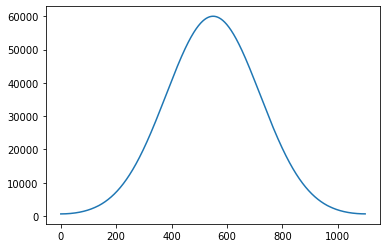

In [29]:
n_cols= 550
s = np.zeros(n_cols*2)
s[n_cols] = 1
fwhm =400
s = ndimage.gaussian_filter(s, fwhm/2.355)
s /= s.max()
s *= power_density*6

fwhm_calc = FWFM.FWFM(np.arange(0,len(s)),s)

plt.plot(s)
print(fwhm_calc)

In [7]:
import FWFM

In [12]:
res = 10
s = np.zeros(n_cols*2)
s[n_cols] = 1
fwhm = 300

fwhm = FWFM.FWFM(np.arange(0,len(s)),s) * res
print(fwhm)

10


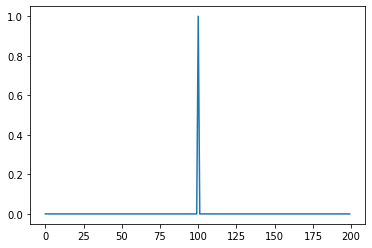

In [11]:
plt.plot(s)

In [ ]:
plt.imshow(m)

In [ ]:
plt.plot(m[:,0])

In [ ]:
plt.plot(m[0,:])

In [ ]:
# create an output widget
rand_num_output = wg.Output()

class Test(object):
    def __init__(self):
        self.random_button = wg.Button(
            description='randomize self.val')
        self.random_button.on_click(self.button_pressed)

    def update_random(self):
        # clear the output on every click of randomize self.val
        rand_num_output.clear_output()
        
        # execute function so it gets captured in output widget view
        with rand_num_output:
            self.val = np.random.rand()
            print(self.val)

    def button_pressed(self,*args):
        self.update_random()

buttonObject = Test()
# display(buttonObject.random_button)  # display works but is not required if on the last line in Jupyter cell.
wg.HBox([buttonObject.random_button, rand_num_output])  # Widget to be dispalyed - must last last line in cell, add output widget

In [ ]:
r = linspace(0, R, n_cols + 1)  # radius values at cell boundaries
r_half = (r[1:] + r[:-1]) / 2  # radius values at cell centers
z = linspace(0, L, n_rows + 1)  # height values at cell boundaries

M = a[0]
C = a[1]
changes = []
N = n_rows * n_cols
T = T_init * ones(N)  # vector of temperatures

for i in tqdm(range(20000)):
    deltaT = M @ T + C
    T += deltaT
    changes.append(deltaT.max())
    

In [ ]:
semilogy(changes)

In [ ]:
r_plot = r[None].repeat(n_rows, axis=0)[:, :-1]
z_plot = z[:, None].repeat(n_cols, axis=1)[:-1, :]

In [ ]:
T_plot = T.reshape(n_rows, n_cols) - 273.15

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
#im = ax.imshow(T_plot,extent=(0, 1 * T_plot.shape[1],(L*1e6)/n_rows * T_plot.shape[0], 1))
im = ax.imshow(T_plot)
colorbar(im,ax = ax)

#ax.set_xlim(0,20)
#ax.set_ylim()

In [ ]:
plt.plot(T_plot[0,:])

In [ ]:
plt.plot(T_plot[:,0])

In [ ]:
T_plot[:,0]

In [ ]:
np.arange(0,)

# Temp class 

In [ ]:
R = 40e-2  # radius of the cylindrical system (m)
L = 400e-6  # height of the cylindrical system (m)
n_rows = 50  # number of rows in the finite volume mesh
n_cols = 200  # number of columns in the finite volume mesh
k = 0.2  # thermal conductivity of substrate (paint) (W/(m K))
C_p = 2500.0  # specific heat capacity of paint (J/(kg K))
rho = 1500.0  # ( = 1.5 g/mL) mass density of paint (kg/m^3)
h = 11.9  # (W/(m^2 K)), converted from 2.1 Btu/(hr ft^2 degF) heat transfer coefficient from the top-facing surface
dt = 1e-5  # timestep (s)
T_inf = 22.5 + 273.15  # 20 degC far-field temperature (K)
T_init = 22.5 + 273.15
RS = 0.1  # mean reflectance over the wavelength range of the input power
power_density = 60000

T = Temp_class.Temp(n_rows,n_cols,R,L,k,C_p,rho,h,dt,T_inf,T_init,RS,power_density)


In [ ]:
T.params()

In [ ]:
mesh = T.T_mesh()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
im = ax.imshow(mesh,origin='upper',extent=(0,(R/n_cols*100) * mesh.shape[1],-(L/n_rows*100000) * mesh.shape[0],0))
#im = ax.imshow(mesh)
colorbar(im,ax = ax, shrink=0.4)

ax.set_xlim(-40,40)
plt.tight_layout()
plt.show()

In [ ]:
extent=[horizontal_min,horizontal_max,vertical_min,vertical_max]

# GIU 

In [2]:
folder = ''
Thermal_model_GIU.T_model(folder)

Accordion(children=(VBox(children=(FloatSlider(value=0.01, description='Radius (m)', layout=Layout(height='30p…

Output()

# questions 

- How come when the radius value is equal or lower than 20, things get mad ?
- How come when the radius value increases so does the temp value ?
- How come when height decreases, the temp value increases ?
- Does the pixels on the image have to be square ?

In [ ]:
# NOTE: all units here are in pure SI (kg, m, s, K as base units)
R = 5e-2  # radius of the cylindrical system (m)
L = 100e-6  # height of the cylindrical system (m)
n_rows = 20  # number of rows in the finite volume mesh
n_cols = 200  # number of columns in the finite volume mesh
dr = R / n_cols  # width of cells
dz = L / n_rows  # height of cells
k = 0.2  # thermal conductivity of substrate (paint) (W/(m K))
C_p = 2500.0  # specific heat capacity of paint (W/(m^2 K))
rho = 1500.0  # ( = 1.5 g/mL) mass density of paint (kg/m^3)
alpha = k / (rho * C_p)  # thermal diffusivity m^2/s
h = 11.9  # (W/(m^2 K)), converted from 2.1 Btu/(hr ft^2 degF) heat transfer coefficient from the top-facing surface
N = n_rows * n_cols  # number of degrees of freedom
dt = 0.1  # timestep (s)
T_inf = 22.5 + 273.15  # 20 degC far-field temperature (K)
T_init = 22.5 + 273.15
f = 0.05  # mean reflectance over the wavelength range of the input power
f'The number of unknown temperatures is {N}.'

Thermal_model.T_model(n_rows, n_cols, R, L, k, C_p, rho, h, dt, T_inf, T_init, f)

In [ ]:
def T_model_GIU():
    
    import Thermal_model
    
    out1 = wg.Output()
    tab = wg.Tab(children=[out1])
    tab.set_title(0, "Results")

    style = {"description_width": "initial"}

    ##### CONSTANTS ######
    '''
    R = wg.IntSlider(
        value=100, 
        min=1,
        max=1000,
        description="Radius",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    L = wg.FloatSlider(
        value=5,
        min=1,
        max=100,
        description="Height",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    n_rows = wg.IntSlider(
        value = 20,
        min=1,
        max=100,
        description="Rows nb",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )

    n_cols = wg.IntSlider(
        value = 200,
        min=1,
        max=1000,
        description="Columns nb",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    k = wg.FloatSlider(
        value=0.2,
        min=0.01,
        max=10,
        step=0.01,
        description="Therm. cond.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    C_p = wg.IntSlider(
        value = 2500,
        min=1,
        max=5000,
        description="Sp. heat cap.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )

    
    rho = wg.FloatSlider(
        value=1500,
        min=0,
        max=5000,
        step=0.01,
        description="Density paint",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    h = wg.FloatSlider(
        value=12,
        min=0,
        max=50,
        step=0.01,
        description="Heat transfer coeff.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    dt = wg.FloatSlider(
        value=0.1,
        min=0,
        max=1,        
        description="Time step",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    T_init = wg.FloatSlider(
        value=300,
        min=0,
        max=500,
        step=0.01,
        description="Initial Temp.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    T_inf = wg.FloatSlider(
        value=300,
        min=0,
        max=500,
        step=0.01,
        description="Far field Temp.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    f = wg.FloatSlider(
        min=0,
        max=1,
        step=0.01,
        description="Reflectance",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    display(
        R,
        L,
        n_rows,
        n_cols,
        k,
        C_p,
        rho,
        h,
        dt,
        T_init,
        T_inf,
        f,
    )
    '''    
    (M,C) = Thermal_model.T_model(n_rows, n_cols, R, L, k, C_p, rho, h, dt, T_inf, T_init, f)
    

    changes = []

    T = T_init * ones(N)  # vector of temperatures

    for i in tqdm(range(10000)):
        deltaT = M @ T + C
        T += deltaT
        changes.append(deltaT.max())

    T_plot = T.reshape(n_rows, n_cols) - 273.15
    

    fig, ax = plt.subplots(1, 1, figsize=(20, 1))
    im = ax.imshow(T_plot)
    cb = plt.colorbar(im, ax = ax)
    cb.ax.tick_params(labelsize=16)

    plt.show()
    '''
    def file_change(change):
        with out1:
            clear_output()
            interact(
                model,
                n_rows=n_rows,
                n_cols=n_cols,
                R=R,
                L=L,
                k=k,
                C_p=C_p,
                rho=rho,
                h=h,
                dt=dt,
                T_inf=T_inf,
                T_init=T_init,
                f=f,
            )

    T_init.observe(file_change, names="value")
    display(tab)
    '''
T_model_GIU()

In [ ]:
50000 * 1.e-6

In [ ]:
def T_model():

    out1 = wg.Output()
    tab = wg.Tab(children=[out1])
    tab.set_title(0, "Results")

    style = {"description_width": "initial"}

    ##### CONSTANTS ######

    R = wg.IntSlider(
        value=100, 
        min=1,
        max=1000,
        description="Radius",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    L = wg.FloatSlider(
        value=3,
        min=0.1,
        max=100,
        description="Height",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    n_rows = wg.IntSlider(
        value = 20,
        min=1,
        max=100,
        description="Rows nb",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )

    n_cols = wg.IntSlider(
        value = 200,
        min=1,
        max=1000,
        description="Columns nb",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    k = wg.FloatSlider(
        value=0.2,
        min=0.01,
        max=10,
        step=0.01,
        description="Therm. cond.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    C_p = wg.IntSlider(
        value = 2500,
        min=1,
        max=5000,
        description="Sp. heat cap.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )

    
    rho = wg.FloatSlider(
        value=1500,
        min=0,
        max=5000,
        step=0.01,
        description="Density paint",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    h = wg.FloatSlider(
        value=12,
        min=0,
        max=50,
        step=0.01,
        description="Heat transfer coeff.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    dt = wg.FloatSlider(
        value=0.1,
        min=0,
        max=1,        
        description="Time step",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    T_init = wg.FloatSlider(
        value=300,
        min=0,
        max=500,
        step=0.01,
        description="Initial Temp.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    T_inf = wg.FloatSlider(
        value=300,
        min=0,
        max=500,
        step=0.01,
        description="Far field Temp.",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    f = wg.FloatSlider(
        min=0,
        max=1,
        step=0.01,
        description="Reflectance",
        layout=Layout(width="30%", height="30px"),
        style=style,
    )


    display(
        R,
        L,
        n_rows,
        n_cols,
        k,
        C_p,
        rho,
        h,
        dt,
        T_init,
        T_inf,
        f,
    )



    ##### TEMPERATURE MODEL ######

    def model(n_rows, n_cols, R, L, k, C_p, rho, h, dt, T_inf, T_init, f):
        # now we construct the M matrix by stepping over every cell and filling in the coefficients on the given
        # cell and the (usually) four neighboring cells
        
        R = R/1000
        L = L/100

        dr = R / n_cols  # width of cells
        dz = L / n_rows  # height of cells
        alpha = k / (rho * C_p)  # thermal diffusivity m^2/s
        N = n_rows * n_cols  # number of degrees of freedom

        s = zeros(400)
        s[200] = 1
        s = ndimage.gaussian_filter(s, 50)
        s /= s.max()
        s *= 60_000

        I = zeros(
            n_cols
        )  # luminous power input (W/m^2) as a function of radius along the top
        I[:] = s[200:]
        
        
        r = linspace(0, R, n_cols + 1)  # radius values at cell boundaries
        r_half = (r[1:] + r[:-1]) / 2  # radius values at cell centers
        z = linspace(0, L, n_rows + 1)  # height values at cell boundaries
        
        
        M = zeros((N, N))  # coefficients in above equation
        C = zeros(N)  # constant term arising from Dirichlet BCs

        for row in tqdm(arange(n_rows)):
            for col in arange(n_cols):
                if row != 0 and row != n_rows - 1:  # neither top nor bottom
                    if col != 0 and col != n_cols - 1:  # also not left or right wall
                        # we are in a typical internal cell
                        coeff = alpha * dt
                        # which DOF number are we considering now; also which M row
                        i = row * n_cols + col
                        
                        i_E = i + 1  # dof for east cell
                        i_W = i - 1  # west cell
                        i_N = i - n_cols
                        i_S = i + n_cols
                        # coeff on east cell:
                        M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                        # coeff on west cell:
                        M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                        M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                        M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                        M[i, i] = -(M[i, i_E] + M[i, i_W] + M[i, i_N] + M[i, i_S])

                    elif (
                        col == n_cols - 1
                    ):  # we are not top or bottom, but we are on the right wall...
                        coeff = alpha * dt
                        # which DOF number are we considering now; also which M row
                        i = row * n_cols + col
                        

                        # there is no east cell...
                        i_W = i - 1  # west cell
                        i_N = i - n_cols
                        i_S = i + n_cols

                        # M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                        # coeff on west cell:
                        M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                        M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                        M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                        # this cell:
                        C[i] = (
                            coeff * (r[col + 1] / r_half[col]) * T_inf / dr ** 2
                        )  # Dirichlet BC
                        M[i, i] = -(
                            (coeff * (r[col + 1] / r_half[col]) / dr ** 2)
                            + M[i, i_W]
                            + M[i, i_N]
                            + M[i, i_S]
                        )
                    else:  # then we are on the left wall
                        coeff = alpha * dt
                        # which DOF number are we considering now; also which M row
                        i = row * n_cols + col
                        i_E = i + 1  # dof for east cell
                        
                        # there is no west cell
                        i_N = i - n_cols
                        i_S = i + n_cols
                        # coeff on east cell:
                        M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                        # coeff on west cell would vanish due to r[col]=0 here:
                        # M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                        M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                        M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                        M[i, i] = -(M[i, i_E] + M[i, i_N] + M[i, i_S])

                else:  # we are top or bottom, but we need to treat them separately
                    if row == n_rows - 1:  # bottom
                        if (
                            col != 0 and col != n_cols - 1
                        ):  # but not the bottom right corner or the bottom left corner
                            coeff = alpha * dt
                            # which DOF number are we considering now; also which M row
                            i = row * n_cols + col
                            
                            i_E = i + 1  # dof for east cell
                            i_W = i - 1  # west cell
                            i_N = i - n_cols
                            # we have no south cell, but we assume a phantom with T=T_inf
                            # coeff on east cell:
                            M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                            # coeff on west cell:
                            M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                            M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                            # M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                            C[i] = (
                                coeff * T_inf / dz ** 2
                            )  # Dirichlet BC for bottom face
                            M[i, i] = -(
                                M[i, i_E]
                                + M[i, i_W]
                                + M[i, i_N]
                                + (coeff * 1 / dz ** 2)
                            )
                        elif col == n_cols - 1:  # we are on the bottom right corner
                            coeff = alpha * dt
                            # which DOF number are we considering now; also which M row
                            i = row * n_cols + col
                            
                            i_W = i - 1  # west cell
                            i_N = i - n_cols
                            # we have no south cell, but we assume a phantom with T_S=T_inf
                            # we also have no east cell, but we assume a phantom with T_E=T_inf
                            # coeff on east cell:

                            # coeff on west cell:
                            M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                            M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                            C[i] = (
                                coeff * T_inf / dz ** 2
                            ) + (  # Dirichlet BC for bottom face
                                coeff * (r[col + 1] / r_half[col]) * T_inf / dr ** 2
                            )  # east face
                            M[i, i] = -(
                                (coeff * (r[col + 1] / r_half[col]) / dr ** 2)
                                + M[i, i_W]
                                + M[i, i_N]
                                + (coeff * 1 / dz ** 2)
                            )
                        else:  # we are on the bottom left corner
                            coeff = alpha * dt
                            # which DOF number are we considering now; also which M row
                            i = row * n_cols + col
                            
                            i_E = i + 1  # dof for east cell
                            i_W = i - 1  # west cell
                            i_N = i - n_cols
                            # we have no south cell, but we assume a phantom with T=T_inf
                            # coeff on east cell:
                            M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                            # we have no west cell

                            M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                            # M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                            C[i] = (
                                coeff * T_inf / dz ** 2
                            )  # Dirichlet BC for bottom face
                            M[i, i] = -(M[i, i_E] + M[i, i_N] + (coeff * 1 / dz ** 2))

                    else:  # we are on the top face
                        if (
                            col != 0 and col != n_cols - 1
                        ):  # but not the upper left or upper right corner
                            coeff = alpha * dt
                            # which DOF number are we considering now; also which M row
                            i = row * n_cols + col
                            

                            i_E = i + 1  # dof for east cell
                            i_W = i - 1  # west cell
                            # we don't have a north cell
                            i_S = i + n_cols
                            # coeff on east cell:
                            M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                            # coeff on west cell:
                            M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                            # there is no north cell M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                            M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                            C[i] = (
                                coeff
                                * (
                                    (h * T_inf)  # heat xfer top BC
                                    + ((1 - f) * I[col])  # luminuous power BC
                                )
                                / (k * dz)
                            )

                            M[i, i] = -(
                                M[i, i_E]
                                + M[i, i_W]
                                + (coeff * h / (k * dz))
                                + M[i, i_S]
                            )

                        elif col == 0:  # the upper left corner
                            coeff = alpha * dt
                            # which DOF number are we considering now; also which M row
                            i = row * n_cols + col
                            
                            i_E = i + 1  # dof for east cell
                            # there is no west cell
                            # we don't have a north cell
                            i_S = i + n_cols
                            # coeff on east cell:
                            M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                            # coeff on west cell:

                            # there is no north cell M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                            M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                            C[i] = (
                                coeff
                                * (
                                    (h * T_inf)  # heat xfer top BC
                                    + ((1 - f) * I[col])  # luminuous power BC
                                )
                                / (k * dz)
                            )

                            M[i, i] = -(M[i, i_E] + (coeff * h / (k * dz)) + M[i, i_S])
                        else:  # the upper right corner cell
                            coeff = alpha * dt
                            # which DOF number are we considering now; also which M row
                            i = row * n_cols + col
                            
                            # we don't have an east cell
                            i_W = i - 1 
                            # west cell
                            # we don't have a north cell
                            i_S = i + n_cols
                            # coeff on east cell:
                            # M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                            # coeff on west cell:
                            M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                            # there is no north cell M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                            M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                            C[i] = (
                                coeff
                                * (
                                    (h * T_inf)  # heat xfer top BC
                                    + ((1 - f) * I[col])  # luminuous power BC
                                )
                                / (k * dz)
                            ) + (coeff * T_inf * (r[col + 1] / r_half[col]) / dr ** 2)

                            M[i, i] = -(
                                (coeff * (r[col + 1] / r_half[col]) / dr ** 2)
                                + M[i, i_W]
                                + (coeff * h / (k * dz))
                                + M[i, i_S]
                            )
        changes = []

        T = T_init * ones(N)  # vector of temperatures

        for i in tqdm(range(1000)):
            deltaT = M @ T + C
            T += deltaT
            changes.append(deltaT.max())

        T_plot = T.reshape(n_rows, n_cols) - 273.15
        print(T_plot)

        fig, ax = plt.subplots(1, 1, figsize=(20, 1))
        im = ax.imshow(T_plot)
        cb = plt.colorbar(im, ax = ax)
        cb.ax.tick_params(labelsize=16)

        plt.show()

    def file_change(change):
        with out1:
            clear_output()
            interact(
                model,
                n_rows=n_rows,
                n_cols=n_cols,
                R=R,
                L=L,
                k=k,
                C_p=C_p,
                rho=rho,
                h=h,
                dt=dt,
                T_inf=T_inf,
                T_init=T_init,
                f=f,
            )

    T_init.observe(file_change, names="value")
    display(tab)

In [ ]:
T_model()

In [ ]:
from ipywidgets import interact, fixed

def g(dat, x_n):
    print(f"dat={dat}, x_n={x_n} from inside g")
    return dat

interact(g, x_n=10, dat=fixed("a"));

In [ ]:
# Problem setup

## Constants

We start by defining certain constants which arise from the geometry of the model as well as thermal and transport properties:

In [ ]:
# NOTE: all units here are in pure SI (kg, m, s, K as base units)
R = 5e-2  # radius of the cylindrical system (m)
L = 100e-6  # height of the cylindrical system (m)
n_rows = 20  # number of rows in the finite volume mesh
n_cols = 200  # number of columns in the finite volume mesh
dr = R / n_cols  # width of cells
dz = L / n_rows  # height of cells
k = 0.2  # thermal conductivity of substrate (paint) (W/(m K))
C_p = 2500.0  # specific heat capacity of paint (W/(m^2 K))
rho = 1500.0  # ( = 1.5 g/mL) mass density of paint (kg/m^3)
alpha = k / (rho * C_p)  # thermal diffusivity m^2/s
h = 11.9  # (W/(m^2 K)), converted from 2.1 Btu/(hr ft^2 degF) heat transfer coefficient from the top-facing surface
N = n_rows * n_cols  # number of degrees of freedom
dt = 1e-5  # timestep (s)
T_inf = 22.5 + 273.15  # 20 degC far-field temperature (K)
T_initial = 22.5 + 273.15
f = 0.05  # mean reflectance over the wavelength range of the input power
f'The number of unknown temperatures is {N}.'

In [ ]:
alpha, dr, dz

In [ ]:
s = zeros(400)
s[200] = 1
s = ndimage.gaussian_filter(s, 10)
s /= s.max()
s *= 60_000
plot(s)

In [ ]:
n_cols

In [ ]:
I = zeros(n_cols)  # luminous power input (W/m^2) as a function of radius along the top
I[:] = s[200:]

plot(I)

## Mesh

Here we define the mesh.  It should be noted that in this setup, the surface of the substrate is at $z=0$ and that increasing values of $z$ move deeper into the substrate (downward).


In [ ]:
r = linspace(0, R, n_cols + 1)  # radius values at cell boundaries
r_half = (r[1:] + r[:-1]) / 2  # radius values at cell centers
z = linspace(0, L, n_rows + 1)  # height values at cell boundaries

In [ ]:
diff(z), dz

In [ ]:
r_half.shape, n_cols

## Problem setup

We will write the time-stepping algorithm as $$\mathbf{T}^{k+1} = \mathbf{T}^{k} + \mathbf{M} \mathbf{T}^{k} + \mathbf{C},$$ where $\mathbf{T}$ is an $N$-dimensional vector of temperature degrees of freedom, superscript indicates timestep number, and $\mathbf{M}$ is an $N\times N$ matrix.

In [ ]:
M = zeros((N, N))  # coefficients in above equation
C = zeros(N)  # constant term arising from Dirichlet BCs

In [ ]:
M[101,103]

In [ ]:
M.shape

In [ ]:
counter = zeros(N)

In [ ]:
# now we construct the M matrix by stepping over every cell and filling in the coefficients on the given
# cell and the (usually) four neighboring cells
for row in tqdm(arange(n_rows)):
    for col in arange(n_cols):
        if row != 0 and row != n_rows - 1:  # neither top nor bottom
            if col != 0 and col != n_cols - 1:  # also not left or right wall
                # we are in a typical internal cell
                coeff = alpha * dt
                # which DOF number are we considering now; also which M row
                i = row * n_cols + col
                counter[i] += 1
                i_E = i + 1  # dof for east cell
                i_W = i - 1  # west cell
                i_N = i - n_cols
                i_S = i + n_cols
                # coeff on east cell:
                M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                # coeff on west cell:
                M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                M[i, i] = -(M[i, i_E] + M[i, i_W] + M[i, i_N] + M[i, i_S])

            elif (
                col == n_cols - 1
            ):  # we are not top or bottom, but we are on the right wall...
                coeff = alpha * dt
                # which DOF number are we considering now; also which M row
                i = row * n_cols + col
                counter[i] += 1

                # there is no east cell...
                i_W = i - 1  # west cell
                i_N = i - n_cols
                i_S = i + n_cols

                # M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                # coeff on west cell:
                M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                # this cell:
                C[i] = (
                    coeff * (r[col + 1] / r_half[col]) * T_inf / dr ** 2
                )  # Dirichlet BC
                M[i, i] = -(
                    (coeff * (r[col + 1] / r_half[col]) / dr ** 2)
                    + M[i, i_W]
                    + M[i, i_N]
                    + M[i, i_S]
                )
            else:  # then we are on the left wall
                coeff = alpha * dt
                # which DOF number are we considering now; also which M row
                i = row * n_cols + col
                i_E = i + 1  # dof for east cell
                counter[i] += 1
                # there is no west cell
                i_N = i - n_cols
                i_S = i + n_cols
                # coeff on east cell:
                M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                # coeff on west cell would vanish due to r[col]=0 here:
                # M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                M[i, i] = -(M[i, i_E] + M[i, i_N] + M[i, i_S])

        else:  # we are top or bottom, but we need to treat them separately
            if row == n_rows - 1:  # bottom
                if (
                    col != 0 and col != n_cols - 1
                ):  # but not the bottom right corner or the bottom left corner
                    coeff = alpha * dt
                    # which DOF number are we considering now; also which M row
                    i = row * n_cols + col
                    counter[i] += 1
                    i_E = i + 1  # dof for east cell
                    i_W = i - 1  # west cell
                    i_N = i - n_cols
                    # we have no south cell, but we assume a phantom with T=T_inf
                    # coeff on east cell:
                    M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                    # coeff on west cell:
                    M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                    M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                    # M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                    C[i] = coeff * T_inf / dz ** 2  # Dirichlet BC for bottom face
                    M[i, i] = -(
                        M[i, i_E] + M[i, i_W] + M[i, i_N] + (coeff * 1 / dz ** 2)
                    )
                elif col == n_cols - 1:  # we are on the bottom right corner
                    coeff = alpha * dt
                    # which DOF number are we considering now; also which M row
                    i = row * n_cols + col
                    counter[i] += 1
                    i_W = i - 1  # west cell
                    i_N = i - n_cols
                    # we have no south cell, but we assume a phantom with T_S=T_inf
                    # we also have no east cell, but we assume a phantom with T_E=T_inf
                    # coeff on east cell:

                    # coeff on west cell:
                    M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                    M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                    C[i] = (coeff * T_inf / dz ** 2) + (  # Dirichlet BC for bottom face
                        coeff * (r[col + 1] / r_half[col]) * T_inf / dr ** 2
                    )  # east face
                    M[i, i] = -(
                        (coeff * (r[col + 1] / r_half[col]) / dr ** 2)
                        + M[i, i_W]
                        + M[i, i_N]
                        + (coeff * 1 / dz ** 2)
                    )
                else:  # we are on the bottom left corner
                    coeff = alpha * dt
                    # which DOF number are we considering now; also which M row
                    i = row * n_cols + col
                    counter[i] += 1
                    i_E = i + 1  # dof for east cell
                    i_W = i - 1  # west cell
                    i_N = i - n_cols
                    # we have no south cell, but we assume a phantom with T=T_inf
                    # coeff on east cell:
                    M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                    # we have no west cell

                    M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell
                    # M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                    C[i] = coeff * T_inf / dz ** 2  # Dirichlet BC for bottom face
                    M[i, i] = -(M[i, i_E] + M[i, i_N] + (coeff * 1 / dz ** 2))

            else:  # we are on the top face
                if (
                    col != 0 and col != n_cols - 1
                ):  # but not the upper left or upper right corner
                    coeff = alpha * dt
                    # which DOF number are we considering now; also which M row
                    i = row * n_cols + col
                    counter[i] += 1

                    i_E = i + 1  # dof for east cell
                    i_W = i - 1  # west cell
                    # we don't have a north cell
                    i_S = i + n_cols
                    # coeff on east cell:
                    M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                    # coeff on west cell:
                    M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                    # there is no north cell M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                    M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                    C[i] = (
                        coeff
                        * (
                            (h * T_inf)  # heat xfer top BC
                            + ((1 - f) * I[col])  # luminuous power BC
                        )
                        / (k * dz)
                    )

                    M[i, i] = -(
                        M[i, i_E] + M[i, i_W] + (coeff * h / (k * dz)) + M[i, i_S]
                    )

                elif col == 0:  # the upper left corner
                    coeff = alpha * dt
                    # which DOF number are we considering now; also which M row
                    i = row * n_cols + col
                    counter[i] += 1
                    i_E = i + 1  # dof for east cell
                    # there is no west cell
                    # we don't have a north cell
                    i_S = i + n_cols
                    # coeff on east cell:
                    M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                    # coeff on west cell:
                    

                    # there is no north cell M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                    M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                    C[i] = (
                        coeff
                        * (
                            (h * T_inf)  # heat xfer top BC
                            + ((1 - f) * I[col])  # luminuous power BC
                        )
                        / (k * dz)
                    )

                    M[i, i] = -(
                        M[i, i_E] + (coeff * h / (k * dz)) + M[i, i_S]
                    )
                else: # the upper right corner cell
                    coeff = alpha * dt
                    # which DOF number are we considering now; also which M row
                    i = row * n_cols + col
                    counter[i] += 1
                    # we don't have an east cell
                    i_W = i - 1  # west cell
                    # we don't have a north cell
                    i_S = i + n_cols
                    # coeff on east cell:
                    # M[i, i_E] = coeff * (r[col + 1] / r_half[col]) / dr ** 2
                    # coeff on west cell:
                    M[i, i_W] = coeff * (r[col] / r_half[col]) / dr ** 2

                    # there is no north cell M[i, i_N] = coeff * 1 / dz ** 2  # coeff on north cell

                    M[i, i_S] = coeff * 1 / dz ** 2  # coeff on south cell

                    C[i] = (
                        coeff
                        * (
                            (h * T_inf)  # heat xfer top BC
                            + ((1 - f) * I[col])  # luminuous power BC
                        )
                        / (k * dz)
                    ) + (coeff * T_inf * (r[col + 1] / r_half[col]) / dr ** 2)

                    M[i, i] = -(
                        (coeff * (r[col + 1] / r_half[col]) / dr ** 2) + M[i, i_W] + (coeff * h / (k * dz)) + M[i, i_S]
                    )
                    



In [ ]:
plot(counter)  # did we write the equation for each cell one and only one time?

In [ ]:
imshow(M)

In [ ]:
plot(C)

## Timestepping from the known initial condition

In [ ]:
changes = []

T = T_initial * ones(N)  # vector of temperatures

for i in tqdm(range(20000)):
    deltaT = M @ T + C
    T += deltaT
    changes.append(deltaT.max())
    # print(T.mean())

In [ ]:
semilogy(changes)

In [ ]:
r_plot = r[None].repeat(n_rows, axis=0)[:, :-1]
z_plot = z[:, None].repeat(n_cols, axis=1)[:-1, :]

In [ ]:
T_plot = T.reshape(n_rows, n_cols) - 273.15

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
im = ax.imshow(T_plot,extent=(0, 0.25 * T_plot.shape[1],0.5 * T_plot.shape[0], 1))
colorbar(im,ax = ax)

ax.set_xlim(0,5)
#ax.set_ylim()

In [ ]:
T_plot.shape[1]*0.25

In [ ]:
c = contour(r_plot, z_plot, T_plot)
# axis('image')
ylim(ylim()[::-1])
clabel(c)

In [ ]:
print(N)